# Working with plant image data as OME-Zarr

## Setup

### Google Colab

In [3]:
!pip install --quiet zarr cellpose

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 17.4 MB/s eta 0:00:00


## What is OME-Zarr and why is it important?

Through this exercise, we'll show how a common format and access mechanism allows us to explore and analyse different plant datasets from public data resources in a consistent way.

## Loading and working with OME-Zarr data

In this section we'll look at:

* Loading OME-Zarr data from a remote location
* Understanding the shape of the data we have loaded
* The difference between "lazy" and full loading

In [4]:
import dask.array as da

In [5]:
def load_ome_zarr_from_uri(uri, path_key='0'):
    array_uri = f"{uri}/{path_key}"

    return da.from_zarr(array_uri)

 Let's look at two different dataset examples from the BioImage Archive (BIA). We'll see how we can use the same access mechanism.

### S-BIAD1018 (BioImage Archive)

* Entry page: https://www.ebi.ac.uk/biostudies/BioImages/studies/S-BIAD1018
* Publication: https://doi.org/10.1083/jcb.202311048
* License: CC BY 4.0

In [6]:
bia_uri = "https://uk1s3.embassy.ebi.ac.uk/bia-integrator-data/S-BIAD1018/85b76b41-210a-486d-b4ff-a7ab6b8d15dc/e4c1178b-eb44-47d8-8474-ba63b4d27fc3.ome.zarr/0"

### S-BIAD1026 (BioImage Archive)

* Entry page: https://www.ebi.ac.uk/biostudies/BioImages/studies/S-BIAD1026
* Publication: https://doi.org/10.1242/dev.202800
* License: CC0

In [ ]:
bia_uri_2="https://uk1s3.embassy.ebi.ac.uk/bia-zarr-test/1135_n_H2BtdTomato.ome.zarr/0"

### Exercise: Load both OME-Zarr files

### Understanding what data we have loaded

In [33]:
load_ome_zarr_from_uri(bia_uri)

/usr/local/lib/python3.10/dist-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


dask.array<from-zarr, shape=(84, 1, 1, 512, 512), dtype=uint8, chunksize=(1, 1, 1, 512, 512), chunktype=numpy.ndarray>

In [9]:
load_ome_zarr_from_uri(bia_uri_2)

dask.array<from-zarr, shape=(1, 1, 264, 1024, 1024), dtype=uint8, chunksize=(1, 1, 1, 1024, 1024), chunktype=numpy.ndarray>

### "Lazy" vs "full" loading

When we initially "load" the OME-Zarr image, what we're actually doing is getting the shape and location of the image arrays. We don't load all of the binary data until we need to.

In [10]:
%%time
bia_array = load_ome_zarr_from_uri(bia_uri)

CPU times: user 31.8 ms, sys: 5.87 ms, total: 37.7 ms
Wall time: 2.79 s


In [11]:
%%time
bia_array_2 = load_ome_zarr_from_uri(bia_uri_2)

/usr/local/lib/python3.10/dist-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [7]:
%%time
full_array = bia_array.compute()

CPU times: user 531 ms, sys: 83.9 ms, total: 615 ms
Wall time: 21.8 s


In [80]:
%%time
full_array_2 = bia_array_2.compute()

CPU times: user 1.74 s, sys: 413 ms, total: 2.16 s
Wall time: 1min 1s


## Visualising OME-Zarr images

Now we've looked at loading, let's examine how we can visualise these images. First we'll define two helper functions:

In [12]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

def select_single_plane(array, t, z, c):
    """Select a single plane from a lazy array, load and return it."""

    return array[t, c, z, :, :].compute()


def scale_to_uint8(array):
    """Given an input array, convert to uint8, including scaling to fill the
    0-255 range.

    Primarily used to convert general numpy arrays into an image rendering
    suitable dtype."""

    scaled = array.astype(np.float32)

    if scaled.max() - scaled.min() == 0:
        return np.zeros(array.shape, dtype=np.uint8)

    scaled = 255 * (scaled - scaled.min()) / (scaled.max() - scaled.min())

    return scaled.astype(np.uint8)

In [13]:
single_plane_bia = select_single_plane(bia_array, t=39, z=0, c=0)

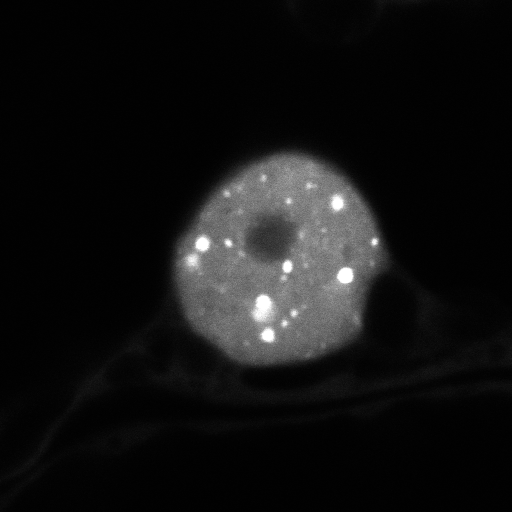

In [14]:
Image.fromarray(single_plane_bia)

In [35]:
single_plane_bia_2 = select_single_plane(bia_array_2, t=0, z=170, c=0)

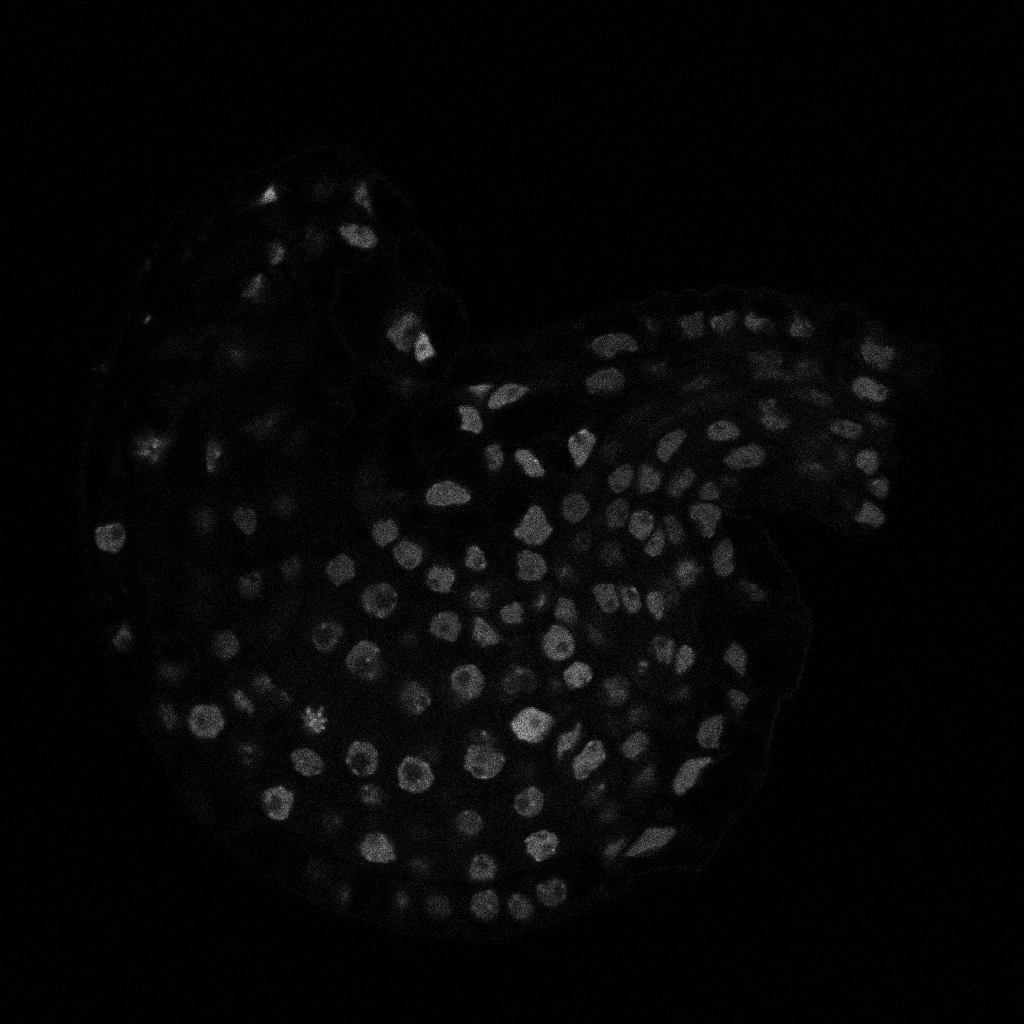

In [18]:
Image.fromarray(single_plane_bia_2)

In [38]:
bia_array.shape

(84, 1, 1, 512, 512)

In [46]:
print("time = {}, channels = {}, z = {}, y = {}, x = {}".format(*bia_array.shape))

time = 84, channels = 1, z = 1, y = 512, x = 512


In [47]:
bia_array_2.shape

(1, 1, 264, 1024, 1024)

<Figure size 640x480 with 0 Axes>

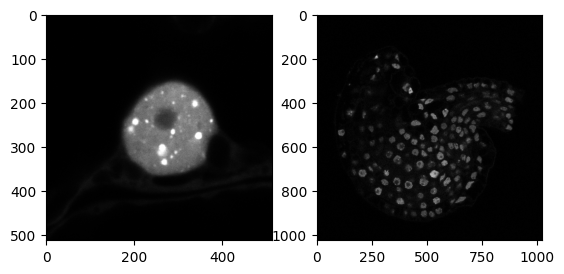

In [48]:
plt.figure()
fig, axes = plt.subplots(1, 2)
axes[0].imshow(single_plane_bia, cmap='gray')
axes[1].imshow(single_plane_bia_2, cmap='gray')


## Computing on OME-Zarr data

In this section, we'll look at:

* How we can run a cutting-edge segmentation algorithm (Cellpose) on OME-Zarr data
* How standardised access makes this easy to repeat on different images.
* Where reference segmentations exist, how we can compare

In [19]:
from cellpose import models, plot

In [20]:
model = models.Cellpose(gpu=False, model_type='cyto')

100%|██████████| 25.3M/25.3M [00:02<00:00, 9.97MB/s]
/usr/local/lib/python3.10/dist-packages/cellpose/resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stat

In [24]:
model_n = models.Cellpose(gpu=False, model_type='nuclei')

/usr/local/lib/python3.10/dist-packages/cellpose/resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, map_location=torch.devi

In [22]:
cellpose_masks_bia, flows_bia, styles, diams = model.eval(single_plane_bia, diameter=None, channels=[0, 0])

In [25]:
cellpose_masks_bia_n, flows_bia_n, styles_n, diams_n = model_n.eval(single_plane_bia, diameter=23, flow_threshold=0.7, channels=[0, 0])

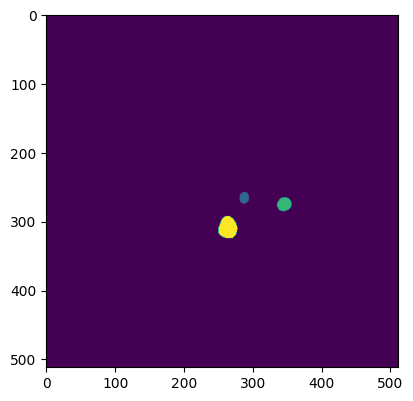

In [26]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(cellpose_masks_bia)

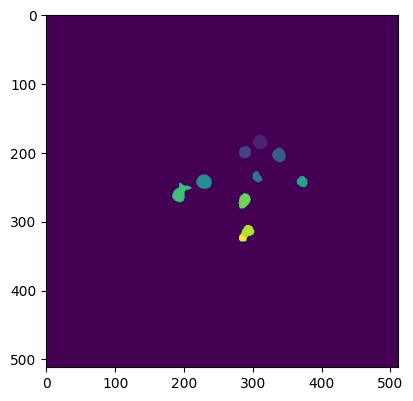

In [27]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(cellpose_masks_bia_n)

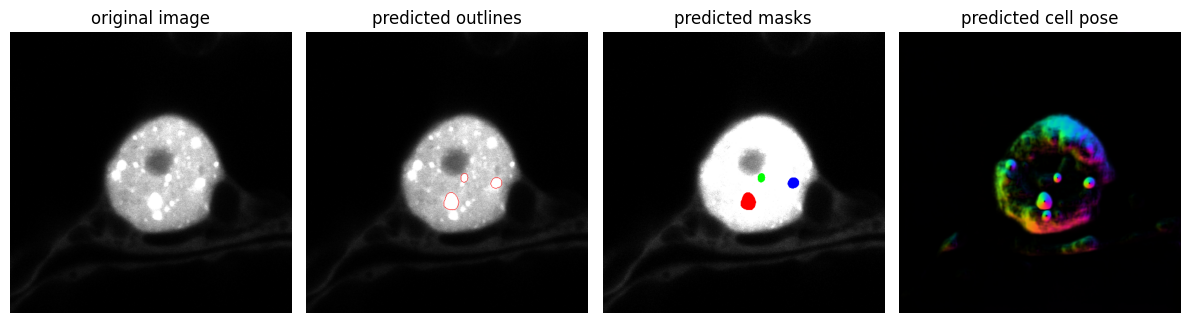

In [28]:
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, single_plane_bia, cellpose_masks_bia, flows_bia[0], channels=[0, 0])
plt.tight_layout()
plt.show()

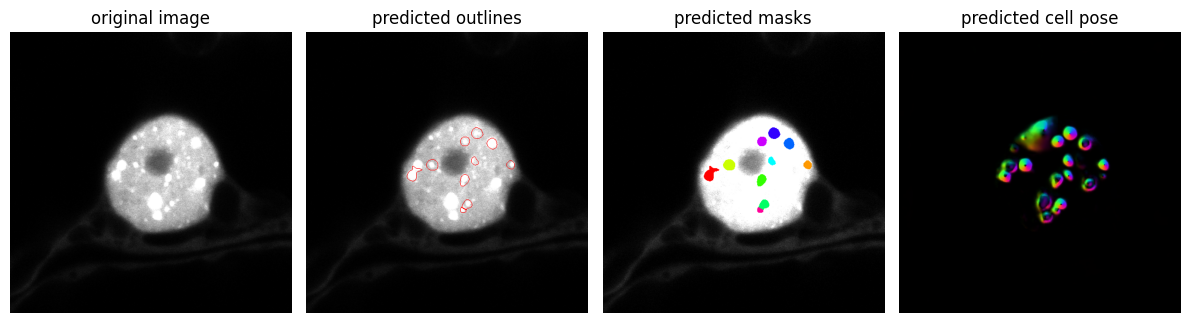

In [29]:
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, single_plane_bia, cellpose_masks_bia_n, flows_bia_n[0], channels=[0, 0])
plt.tight_layout()
plt.show()

In [30]:
cellpose_masks_bia_2, flows_bia_2, styles_2, diams_2 = model.eval(single_plane_bia_2, diameter=None, channels=[0, 0])

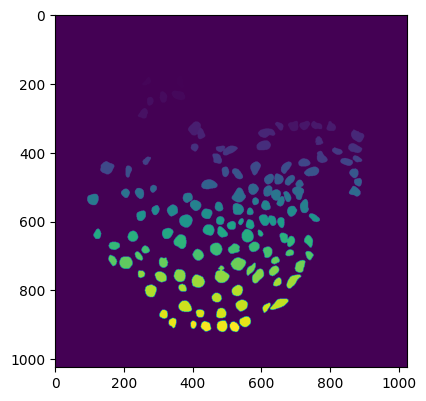

In [31]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(cellpose_masks_bia_2)

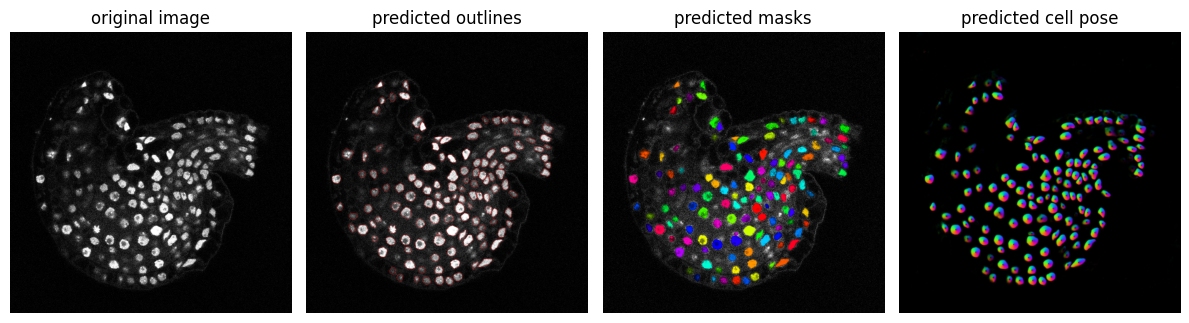

In [32]:
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, single_plane_bia_2, cellpose_masks_bia_2, flows_bia_2[0], channels=[0, 0])
plt.tight_layout()
plt.show()

In [74]:
plot_array = plot.mask_overlay(single_plane_bia_2, cellpose_masks_bia_2)

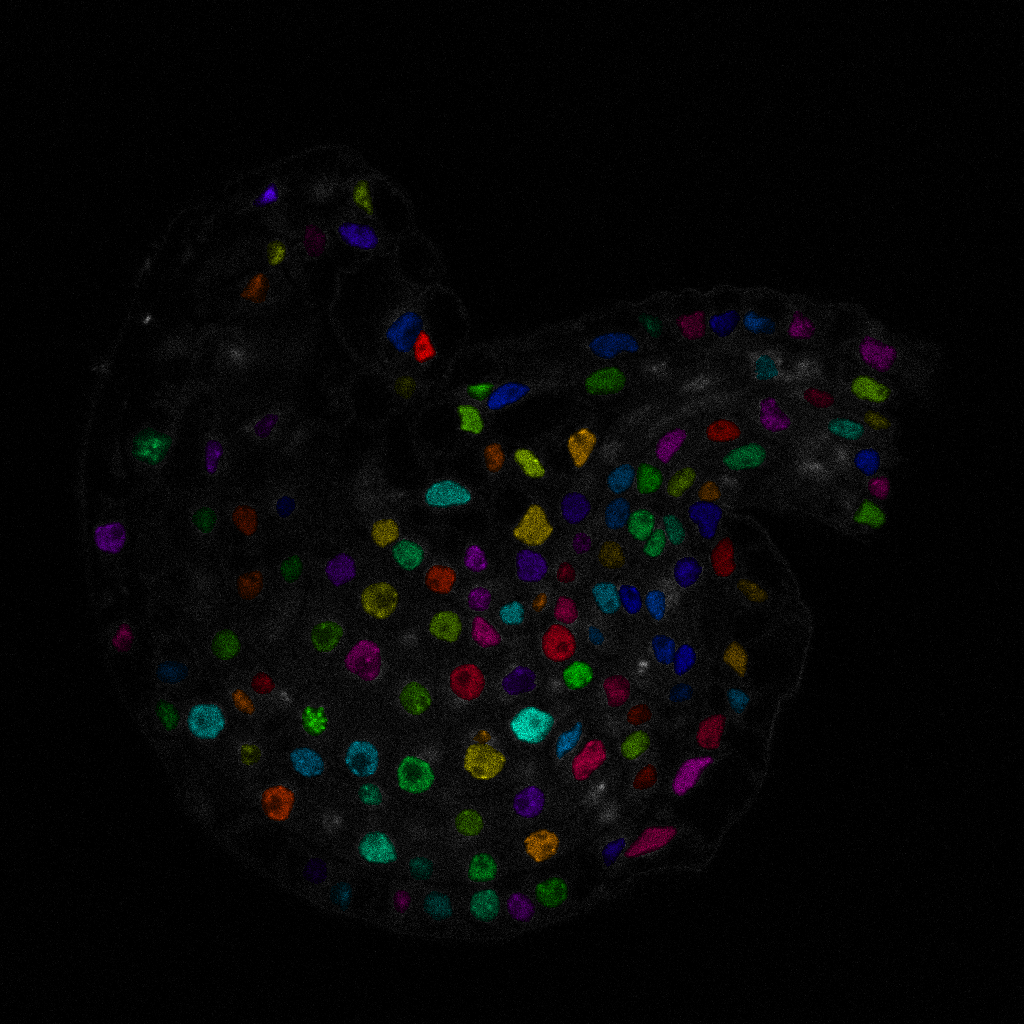

In [75]:
Image.fromarray(plot_array)

### Comparing with reference segmentation masks

For one of these images, we also have access to reference "ground truth" segmentations. Let's look at how we can load and visualise them.

In [51]:
bia_2_labels_uri = "https://uk1s3.embassy.ebi.ac.uk/bia-zarr-test/1135_n_stain_StarDist_goldGT_180_rotation.ome.zarr/0"

In [52]:
bia_labels_image = load_ome_zarr_from_uri(bia_2_labels_uri)

/usr/local/lib/python3.10/dist-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [53]:
single_plane_bia_labels = select_single_plane(bia_labels_image, 0, 170, 0)

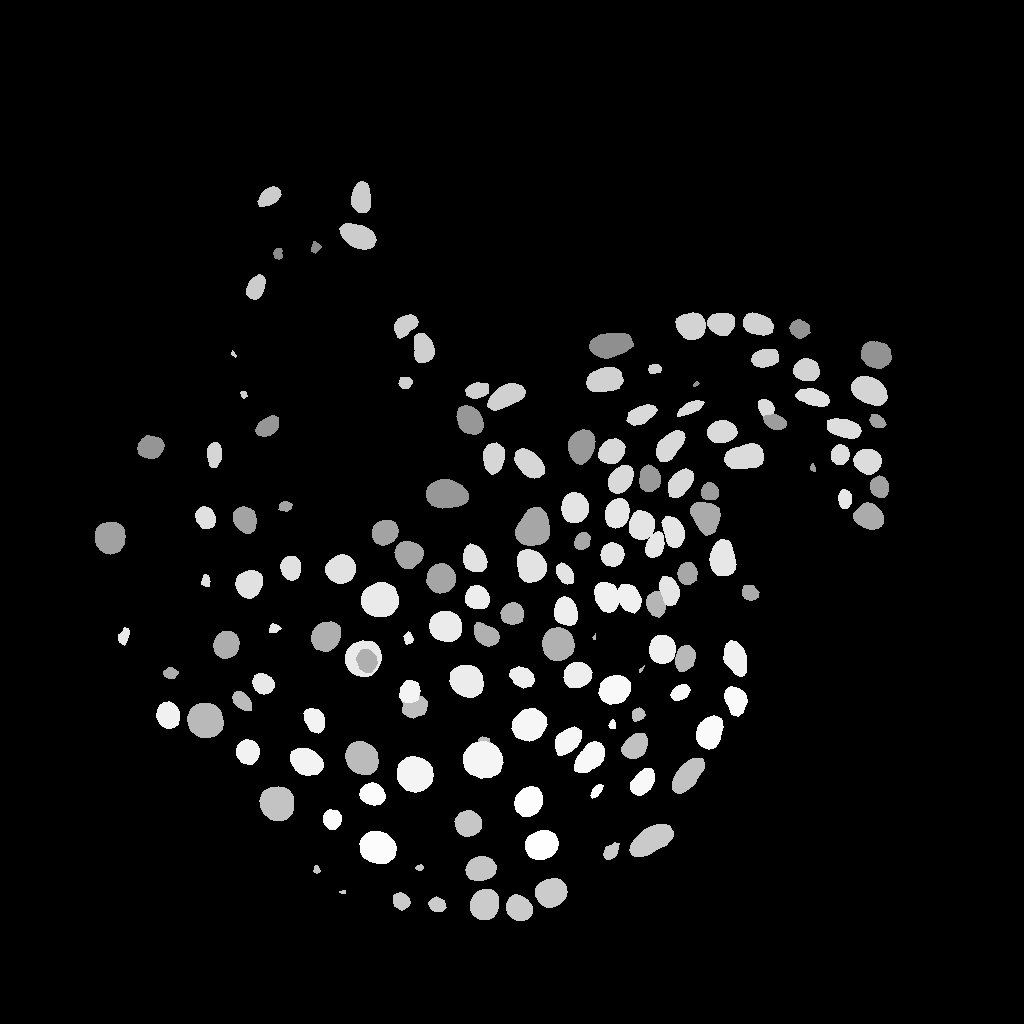

In [54]:
Image.fromarray(scale_to_uint8(single_plane_bia_labels))

<Figure size 640x480 with 0 Axes>

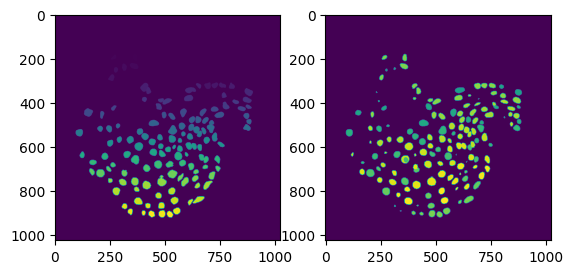

In [78]:
plt.figure()
fig, axes = plt.subplots(1, 2)
axes[0].imshow(cellpose_masks_bia_2)
axes[1].imshow(single_plane_bia_labels)